# Telecommunications customer retention

## Overview

In this project, I'll be trying to build a machine learning classifier to determine whether or not customers of a telecommunications company will terminate their service. This sort of predictive modelling can be very beneficial to businesses as a basis for targeted marketing, offers, etc., to attempt to retain customers who have a high likelihood of leaving. It can also indicate the particular services offered by the company that customers are not happy with, and appear to cause them to terminate their subscriptions.

## Data cleaning

The data can be found at https://www.kaggle.com/blastchar/telco-customer-churn, and tells us various information about the customers and their subscription, and whether they terminated their service (referred to as "churn" of the customer) over a one month period. Let's import the data into a pandas dataframe.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('customer_retention_dataset.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


There's a lot of data collected for each customer, some variables being numerical (eg "tenure", which tells us how many months the customer has had their service), and some variables having string values (eg "InternetService", which tells us the type of internet connection the customer is getting with their service). In order to process any data of this latter form, it's important to convert these strings into numbers.

In [2]:
labels = {}
dataNum = pd.DataFrame() # Holds new data

# Take a column of the original dataframe, and output that column with each string entry replaced with a corresponding
# integer, which is given by the index of the string in labels[column].
def labelWithNumbers(column):
    # Get unique entries of the column
    entries = data[column].unique().tolist()
    
    # Ignore columns with data that is already numeric
    if type(entries[0]) != str:
        dataNum[column] = data[column]
        return 'Already numeric'
    
    # If column contains binary yes/no data, always make 0 correspond to no and 1 correspond to yes
    if entries == ['Yes', 'No']:
        entries = ['No', 'Yes']
        
    # Replace column entries with their associated index in the 'entries' list
    dataNum[column] = data[column].map(lambda x: entries.index(x))
    
    # Write entries/index to labels dictionary
    labels.update({column : entries})
    
    return 'Successful'

This function will take a column of the dataframe, and, for each unique string value appearing in the column, replace each instance of this string with a particular number. The mappings of indices to strings for the column will then be stored in the "labels" dictionary.

Let's apply this to all the columns in the dataframe.

In [3]:
for i in list(data):
    labelWithNumbers(i)

dataNum.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,29.85,0,0
1,1,1,0,0,0,34,1,1,0,1,...,1,0,0,0,1,0,1,56.95,1,0
2,2,1,0,0,0,2,1,1,0,1,...,0,0,0,0,0,1,1,53.85,2,1
3,3,1,0,0,0,45,0,0,0,1,...,1,1,0,0,1,0,2,42.30,3,0
4,4,0,0,0,0,2,1,1,1,0,...,0,0,0,0,0,1,0,70.70,4,1


This data looks more appropriate. If we want to see what these values mean, we can look them up in the labels dictionary.

In [4]:
labels['InternetService']

['DSL', 'Fiber optic', 'No']

So, in the "InternetService" column of this new dataframe, a 0 corresponds to "DSL", 1 corresponds to "Fiber optic", and 2 corresponds to "No".

There's one anomaly in the data we need to deal with. In the original dataset, the "TotalCharges" column contains float numbers, but for some reason they are represented as strings. We'll need to convert them to float numbers for them to be processed correctly. In this column, there appears to be 11 blank entries "' '". We may as well delete these whole rows so the data is completely consistent.

There are a few other processes to apply, such as deleting the unnecessary "customerID" column, adding the "SeniorCitizen" column to the labels dictionary (this column anomalously had 0/1 entries instead of "No"/"Yes"), and removing the "TotalCharges" column from the labels dictionary.

In [5]:
# Convert strings to float, returning NaN for the string " "
def strToFloat(s):
    if s == ' ': # If entry is empty, cast as nan (row will then be deleted)
        return np.nan
    return float(s)

# Apply function to get TotalCharges column with float entries, then delete row with NaN entry
dataNum['TotalCharges'] = data['TotalCharges'].map(strToFloat)
dataNum = dataNum.dropna()

# Delete customerID column as it isn't needed
if 'customerID' in list(dataNum):
    dataNum = dataNum.drop(columns = ['customerID'])

# Also delete these columns from the labels dictionary
if 'customerID' in labels:
    del labels['customerID']
    del labels['TotalCharges']

# Also, add senior citizen column to labels 
labels.update({'SeniorCitizen' : ['No', 'Yes']})

# View new dataframe
dataNum.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,29.85,29.85,0
1,1,0,0,0,34,1,1,0,1,1,1,0,0,0,1,0,1,56.95,1889.50,0
2,1,0,0,0,2,1,1,0,1,0,0,0,0,0,0,1,1,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,1,1,1,0,0,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,1,1,0,1,0,0,0,0,0,1,0,70.70,151.65,1


## Data exploration - identifying loyal demographics

In [6]:
import matplotlib.pyplot as plt

Now that the data is in a consistent, clean state, let's have a look at what it tells us. Firstly, the proportion of customers who terminated their services:

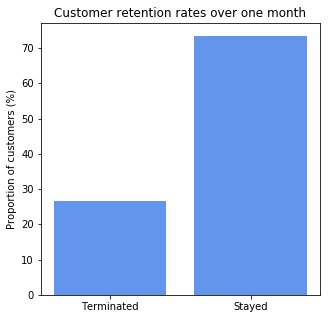

In [7]:
churn = (np.array(dataNum.Churn) == 1).sum()/len(np.array(dataNum.Churn))

plt.figure(figsize=(5,5))
plt.bar(['Terminated', 'Stayed'], [100 * churn, 100*(1-churn)], color='cornflowerblue')
plt.title('Customer retention rates over one month')
plt.ylabel('Proportion of customers (%)')
plt.show()

So, over a one month period, we can expect around 27% of customers to terminate their service. Let's see if we can discern any trends regarding who is likely to terminate their service.

We have a number of columns, such as "PaymentMethod", each with a number of possible values, such as "Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)". For each column and for each possible value, let's find the rate of customer retention, which can interpreted as the probability for a customer to terminate their service over a period of one month.

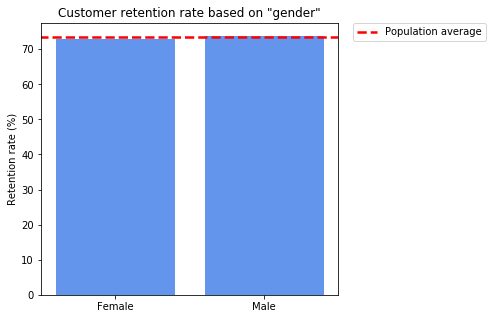

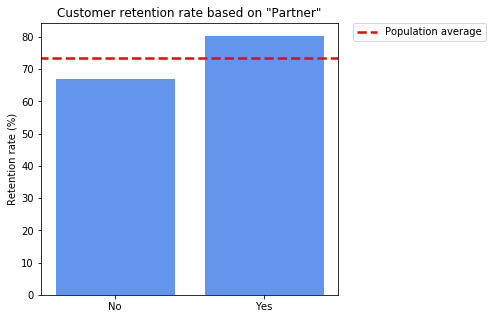

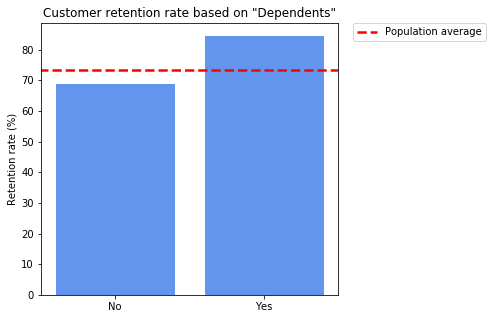

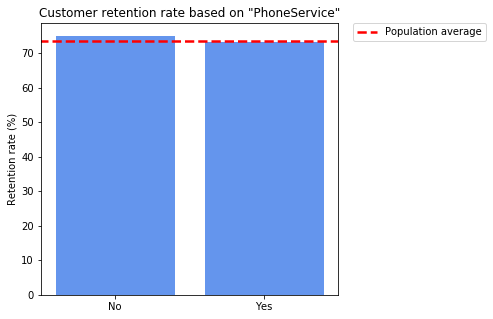

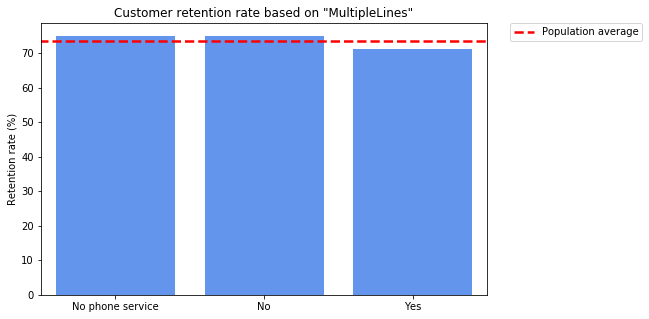

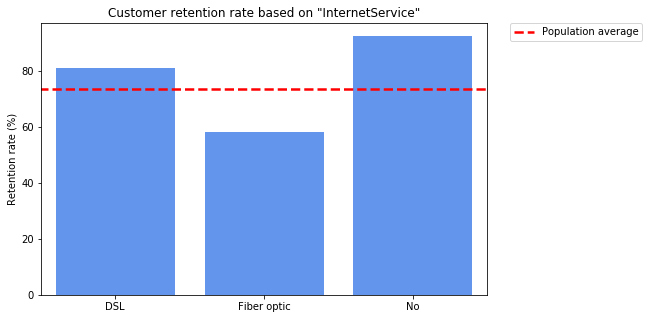

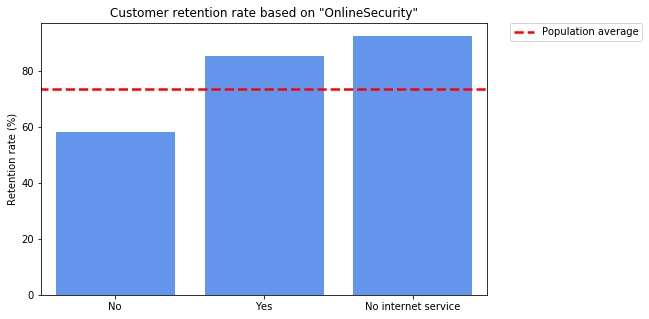

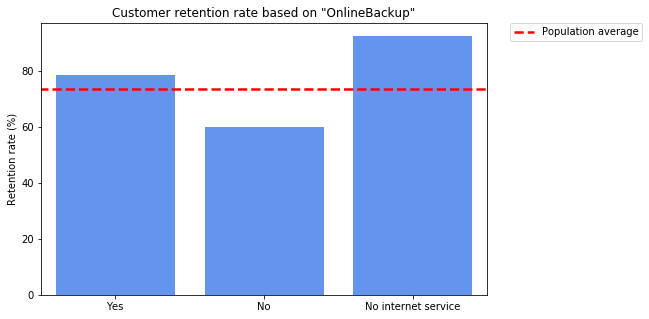

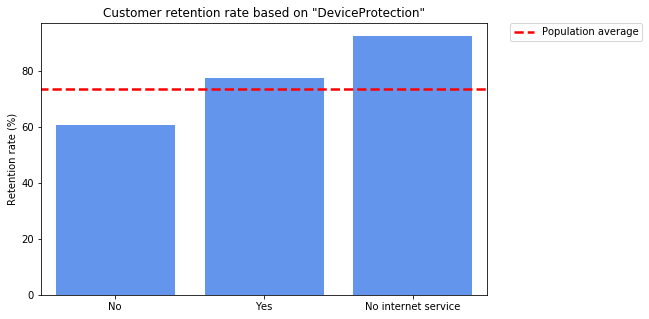

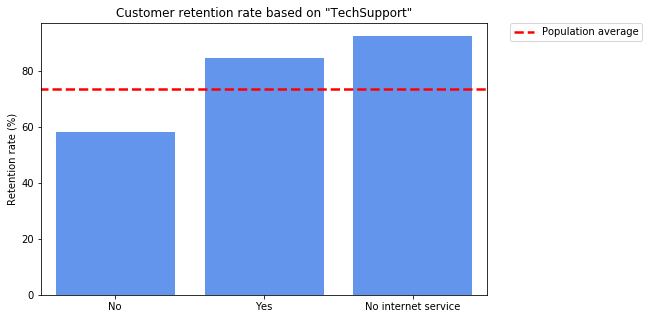

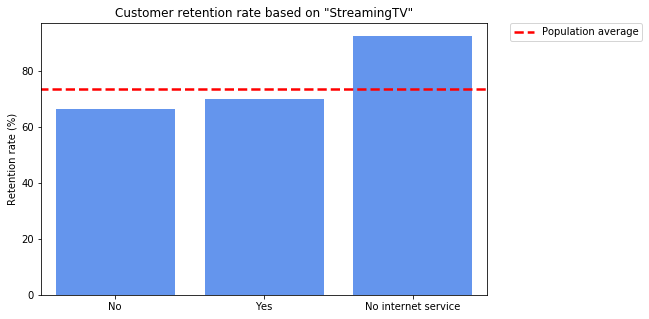

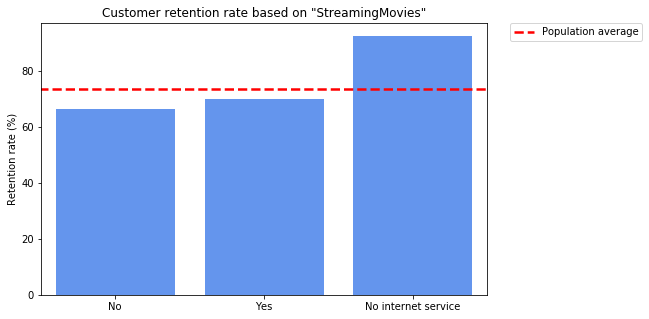

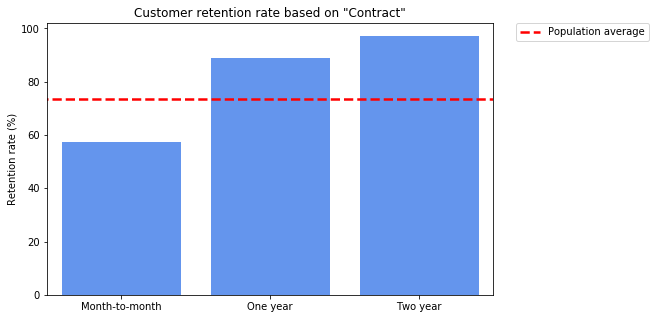

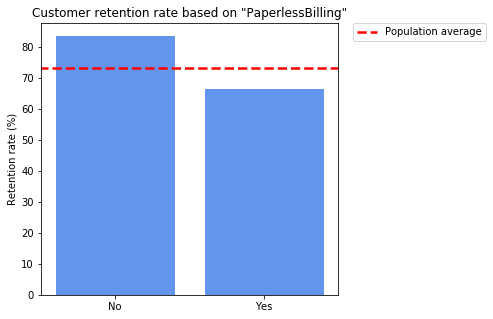

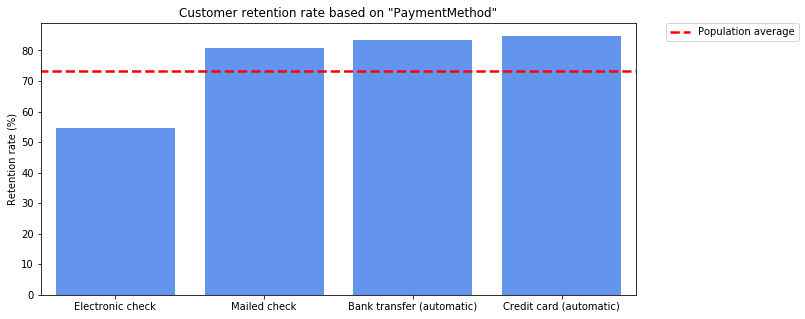

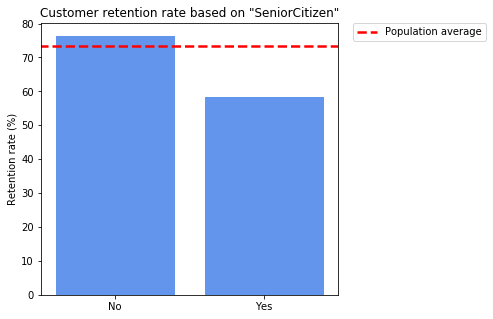

In [8]:
# Calculate retention rate of customers in dataframe df (which will have limited entries based on some condition on the population)
retentionRate = lambda df: ((np.array(df.Churn) == 0).sum() / len(df))# / (1 - churn)

# For each (originally) non-numerical column of the data, create a bar chart showing retention rate
# for each possible value appearing in the column
for feature, labelList in labels.items():
    if feature != 'Churn':
        # Get retention rate for each possible value of the column
        rrList = []
        for index, value in enumerate(labelList):
            rr = 100 * retentionRate(dataNum[dataNum[feature] == index])
            rrList.append(rr)
        
        # Make bar chart
        plt.figure(figsize=(8*len(labelList)/3,5))
        plt.bar(labelList, rrList, color='cornflowerblue')
        plt.plot([-100, 100], [100 - 100 * churn, 100 - 100 * churn], '--', color='r', linewidth = 2.5, label='Population average')
        plt.xlim([-0.5, len(labelList) - 0.5])
        plt.title('Customer retention rate based on \"' + feature + '\"')
        plt.ylabel("Retention rate (%)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()

Some observations:

I believe age, as indicative of one's sitation in life, to be a significant factor. Young, single people without children are relatively likely to cancel their service, whereas people with partners and/or children who are more settled down in life are more likely to stay subscribed. This changes for senior citizens, who are significantly more likely to terminate their service than non-senior citizens.

Users with fibre optic internet were more likely to terminate their services than those with a DSL connection, who were in turn more likely to leave than those with no internet service. It's hard to pin down the reason for this, but one possibility is that young subscribers are more likely to get an internet service, and are more likely to choose fibre optic internet service. Another possibility is that these services are dissatisfactory for users, who are turning to competitors, who are turning to competitors for fibre optic, and, to a lesser extent, DSL, internet service.

Users who subsribed to additional packages (the online security package, the online backup service, the device protection package, and special tech support service) were also less likely to terminate their service. I would attribute this to two causes, namely that subscribers with these additional services are more satisfied with the company, and that users who are happy to pay extra for these services are likely to not have the financial concerns which cause other users to look for a different company.

Finally, users who pay using electronic checks and/or use paperless billing are more likely to cancel their subscriptions, and those who have automatic payments set up are more likely to stay with the company.

Now, let's perform the same sort of analysis on the columns with numerical values, i.e., tenure, monthly charges, and total charges. For each of these columns, we can divide the possible values into 30 brackets, and, in a new dataframe, specify which bracket each value falls into. This allows us to plot the customer retention rate as a function of this column.

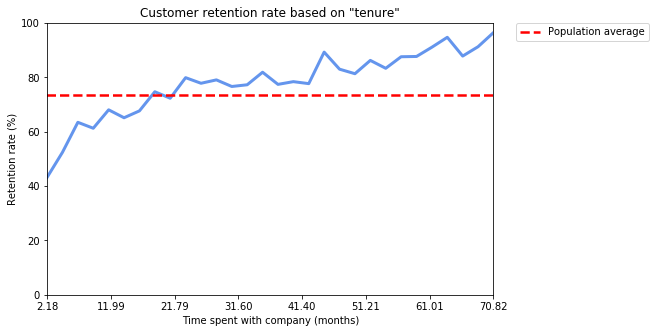

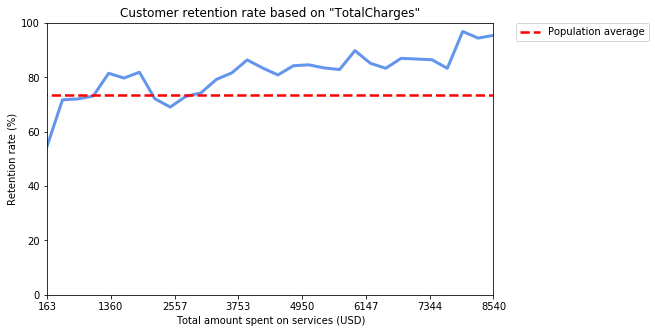

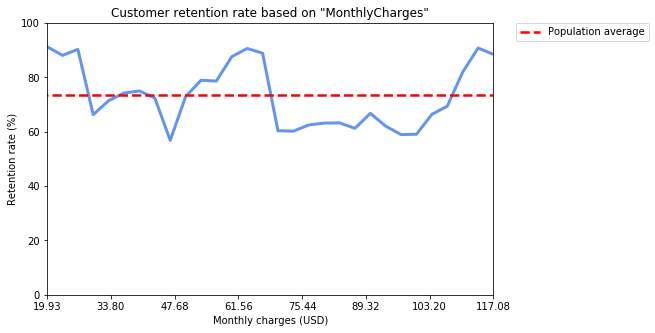

In [9]:
# Number of brackets to divide data into
numBrackets = 30

# Columns to consider
numericalCols = ['tenure', 'TotalCharges', 'MonthlyCharges']

# Dictionary of bracket middlepoints
numLabels = {}

# Define new dataframe containing bracketed data
dataBracket = pd.DataFrame()
dataBracket["Churn"] = dataNum["Churn"]

# Convert values into brackets and add to dataframe
for col in numericalCols:
    # Array of data in original column
    values = np.array(dataNum[col])
    
    # Get endpoints of brackets
    bracketEndpoints = np.linspace(np.min(values), np.max(values), numBrackets + 1)
   
    # Fill new list telling us which bracket the values fall into
    bracketValues = []
    for value in values:
        for i in range(numBrackets):
            if bracketEndpoints[i] <= value < bracketEndpoints[i + 1]:
                index = i
            elif value == bracketEndpoints[-1]:
                index = numBrackets - 1
        bracketValues.append(index)
    
    # Put in new column of dataframe
    dataBracket[col] = bracketValues
    
    # Add label to labels dictionary
    numLabels.update({col : [((bracketEndpoints[i] + bracketEndpoints[i + 1]) / 2) for i in range(numBrackets)]})
    
bracketPlotxLabels = {'tenure' : 'Time spent with company (months)', 'MonthlyCharges' : 'Monthly charges (USD)', 'TotalCharges' : 'Total amount spent on services (USD)'}

# Plot each result
for col in list(dataBracket)[1:]:
    countBracket = [100 * retentionRate(dataBracket[dataBracket[col] == bracket]) for bracket in range(numBrackets)]
    
    plt.figure(figsize=(8,5))
    plt.plot(numLabels[col], countBracket, linewidth = 3, color='cornflowerblue')
    plt.plot([0, 10000], [100 - 100 * churn, 100 - 100 * churn], '--', color='r', linewidth = 2.5, label='Population average')


    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.title('Customer retention rate based on \"' + col + '\"')
    plt.xlim([np.min(numLabels[col]), np.max(numLabels[col])])
    plt.ylim([0, 100])
    plt.xticks(np.linspace(np.min(numLabels[col]), np.max(numLabels[col]), 8))
    plt.xlabel(bracketPlotxLabels[col])
    plt.ylabel('Retention rate (%)')
    plt.show()

This data is somewhat noisy, making it difficult to confidently draw any conclusions from it, but there seems to be a clear trend in "tenure", where the loyal customers who have spent longer with the company are less likely to leave its service. In fact, it takes approximately 20 months for new customers to reach the general population probability of staying with the company.

The total charges trend seems to roughly mimic this, except for a dip for customers who have spent $250 with the company where the retention rate drops below the population average. I'm not sure what the cause of this is.

The monthly charges trend is complex. There appear to be three main price ranges where customers are more likely to stay with the company:

- Below \\$30, where customers appear to be happy with the cheapness of the simplest services available
- Between \\$50 and \\$70, where customers are likely getting good value for money
- Above \\$110, where customers are satisfied with the best, most expensive services

All other monthly price ranges have lower customer retention. A particularly high risk range is monthly costs between \\$70 and \\$110, where perhaps the value for money is not as good.

So, in conclusion, the customers who are the least likely to cancel their service are:

1) People with long-term contracts (1-2 years)

2) People who have been with the company for a long time (3+ years)

3) People who have simpler internet services, i.e. no internet, or a DSL connection

4) People who subscribe to extra features

5) People with automatic payments set up, people who pay with a mailed check, and/or those who do not use paperless billing.

6) Families

## Predictive modelling

Now, let's see how powerful the features of the customer's subscriptions are when it comes to predicting whether or not they terminate their service.

Let's set up the features and labels, and split into training and testing data.

In [10]:
features = dataNum.loc[:, dataNum.columns != 'Churn'].columns.tolist()
X = np.array(dataNum.loc[:, dataNum.columns != 'Churn'])
Y = np.array(dataNum.Churn)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

Now, more customers stay with the company than leave, so we have imbalanced data. To address this, we can oversample the minority class so that we train the classifiers on unskewed data. This can be done using imblearn's RandomOverSampler.

In [11]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state = 555)
X_train, y_train = sampler.fit_sample(X_train, y_train)

I'll define a function to calculate some performance metrics for the classifiers. Specifically, we're interested in the recall and precision of both classes. The recall of a class is the fraction of data in that class that was correctly classified, and the precision of a class is the fraction of the data classified in a certain class that actually belongs to that class.

In [12]:
def recall_precision(y_test, pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    
    acc = accuracy_score(y_test, pred)
    
    C = confusion_matrix(y_test, pred)
    #C[i,j] gives number of points in class i classified into class j

    rec0 = C[0,0]/(C[0,0] + C[0,1])
    prec0 = C[0,0]/(C[0,0] + C[1,0])
    rec1 = C[1,1]/(C[1,1] + C[1,0])
    prec1 = C[1,1]/(C[1,1] + C[0,1])

    print("Returning customer recall: %.0f%%" % (100 * rec0))
    print("Terminating customer recall: %.0f%%" % (100 * rec1))
    print("Returning customer precision: %.0f%%" % (100 * prec0))
    print("Terminating customer precision: %.0f%%" % (100 * prec1))
    print("Overall classification accuracy: %.0f%%" % (100 * acc))
    return

Let's try some different machine learning algorithms, with only a little bit of parameter tweaking.

Gaussian Naive Bayes:

In [13]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

recall_precision(y_test, pred)

Returning customer recall: 64%
Terminating customer recall: 85%
Returning customer precision: 92%
Terminating customer precision: 46%
Overall classification accuracy: 70%


Logistic regression:

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

recall_precision(y_test, pred)

Returning customer recall: 73%
Terminating customer recall: 81%
Returning customer precision: 92%
Terminating customer precision: 52%
Overall classification accuracy: 75%


Support vector machine:

In [15]:
from sklearn.svm import SVC
clf = SVC(kernel = 'rbf', C = 0.5, gamma = 'scale')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

recall_precision(y_test, pred)

Returning customer recall: 74%
Terminating customer recall: 73%
Returning customer precision: 88%
Terminating customer precision: 50%
Overall classification accuracy: 74%


A decision tree classifier:

In [16]:
from sklearn.tree import DecisionTreeClassifier as DTC
clf = DTC(min_samples_split = 3)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

recall_precision(y_test, pred)

Returning customer recall: 83%
Terminating customer recall: 50%
Returning customer precision: 82%
Terminating customer precision: 53%
Overall classification accuracy: 75%


Gradient boosting:

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_depth = 3)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

recall_precision(y_test, pred)

Returning customer recall: 74%
Terminating customer recall: 81%
Returning customer precision: 91%
Terminating customer precision: 53%
Overall classification accuracy: 76%


Random forest:

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, max_depth = 9)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

recall_precision(y_test, pred)

Returning customer recall: 78%
Terminating customer recall: 79%
Returning customer precision: 91%
Terminating customer precision: 56%
Overall classification accuracy: 78%


Out of all these, I think the random forest classifier is the most effective, with high recall for both returning and terminating customers. To summarise what these quantities mean, our classifier correctly predicted the  of 78% of returning customers, and 79% of terminating customers. Of all the customers we would predict as terminating their service, only 56% actually terminated their service. This may not sound very precise, but this is a difficult job --  the few variables we have access to don't let us read the customers' minds!

This classifier allows us to process our sample of customers, who have a 27% chance of cancelling their service, into a reduced sample of approximately one third of the customers, who have a 56% chance of cancelling their service. This reduced sample can be the target of some promotional offers, such as discounted and free additional services, in an attempt to keep them from leaving.

### Feature importance

Using the random forest classifier, we can look at the ranking of importance for all the features in predicting customer retention.

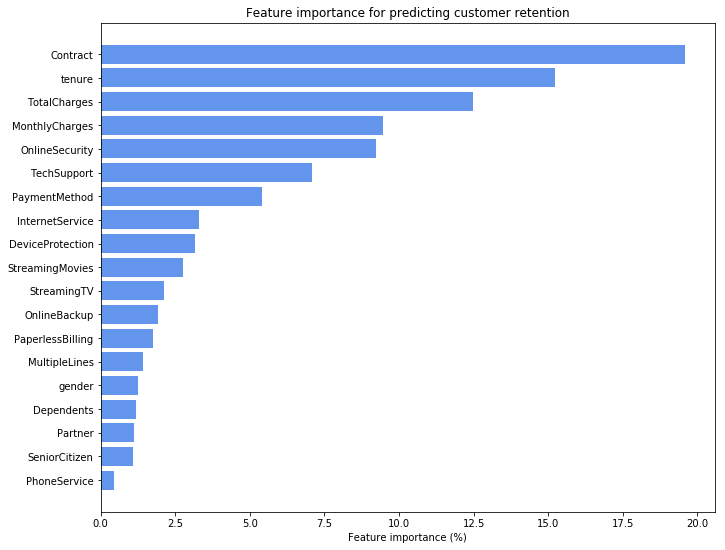

In [19]:
# Get importance of each feature from random forest classifier
imp = clf.feature_importances_

# Sort list of features and importances
features_sorted = [x for _, x in sorted(zip(imp, features))]
imp_sorted = sorted(imp)

# Plot importances
plt.figure(figsize = (11,9))
plt.title('Feature importance for predicting customer retention')
plt.xlabel('Feature importance (%)')
plt.barh(features_sorted, 100 * np.array(imp_sorted), color='cornflowerblue')
plt.show()

So we can see that the most significant factors in determining whether a customer will stay with the company is the length of their contract, how long they have been with the company, the total amount of money they have spent on their services, and how much they pay per month. Oddly, the "dependents" and "partner" features are very low ranked, even lower than "gender", despite both of these columns having quite a high correlation with customer retention and gender having effectively none. I'm not sure why this is the case, perhaps the classifier isn't leveraging all the information it can from the data.